# Data analysis for rotating field

Data files comes in matrices having as rows increasing time-steps and as columns
- time 
- continuous FI 11
- continuous FI 12
- continuous FI 22
- FI on conditional state 11
- FI on conditional state 12
- FI on conditional state 22
- QFI 11
- QFI 12
- QFI 22
- absolute value of D 12

In [1]:
using Plots
using DelimitedFiles
using LinearAlgebra

### Homodyne detection

In [2]:
hd = readdlm("File_julia/Output_Rotating_HD.dat");

Components of the Fisher Information for the homodyne detection, Quantum Fisher Information and Fisher Information for the strong measurement on the conditional state

In [3]:
label1 = ["FI_ΩΩ" "FIC_ΩΩ" "QFI_ΩΩ"]
label2 = ["FI_Ωω" "FIC_Ωω" "QFI_Ωω"]
label3 = ["FI_ωω" "FIC_ωω" "QFI_ωω"]

p1 = plot(hd[:,1], [hd[:,2], hd[:,8], hd[:,5]], xlabel = "t", label = label1) 
p2 = plot(hd[:,1], [hd[:,3], hd[:,9], hd[:,6]], xlabel = "t", label = label2) 
p3 = plot(hd[:,1], [hd[:,4], hd[:,10], hd[:,7]], xlabel = "t", label = label3) 
plot(p1, p2, p3, layout = (3,1), xlim = (0,7))

Module of the Uhlmann curvature

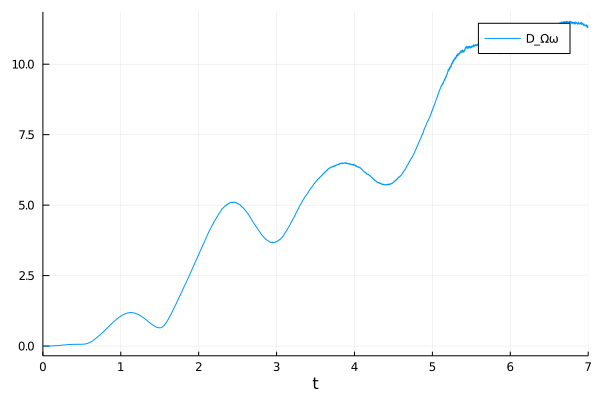

In [4]:
p = plot(hd[:,1], hd[:,11], xlabel = "t", label = "D_Ωω", xlim = (0,7))
plot(p)

### Heterodyne detection

In [5]:
hed = readdlm("File_julia/Output_Rotating_HED.dat");

Components of the Fisher Information for the heterodyne detection, Quantum Fisher Information and Fisher Information for the strong measurement on the conditional state

In [6]:
p1 = plot(hed[:,1], [hed[:,2], hed[:,8], hed[:,5]], xlabel = "t", label = label1) 
p2 = plot(hed[:,1], [hed[:,3], hed[:,9], hed[:,6]], xlabel = "t", label = label2) 
p3 = plot(hed[:,1], [hed[:,4], hed[:,10], hed[:,7]], xlabel = "t", label = label3) 
plot(p1, p2, p3, layout = (3,1), xlim = (0,7))

Module of the Uhlmann curvature

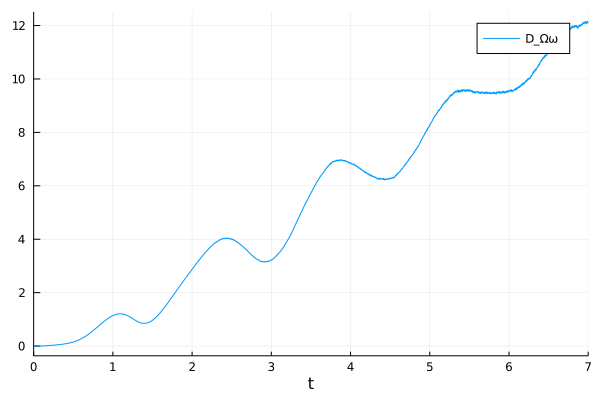

In [7]:
p = plot(hed[:,1], hed[:,11], xlabel = "t", label = "D_Ωω", xlim = (0,7))
plot(p)

### Photodetection

In [8]:
pd = readdlm("File_julia/Output_Rotating_PD.dat");

Components of the Fisher Information for the photodetection, Quantum Fisher Information and Fisher Information for the strong measurement on the conditional state

In [9]:
p1 = plot(pd[:,1], [pd[:,2], pd[:,8], pd[:,5]], xlabel = "t", label = label1) 
p2 = plot(pd[:,1], [pd[:,3], pd[:,9], pd[:,6]], xlabel = "t", label = label2) 
p3 = plot(pd[:,1], [pd[:,4], pd[:,10], pd[:,7]], xlabel = "t", label = label3) 
plot(p1, p2, p3, layout = (3,1), xlim = (0,7))

Module of the Uhlmann curvature

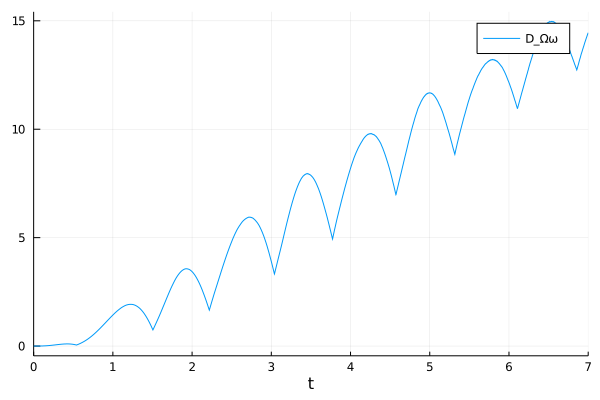

In [10]:
p = plot(pd[:,1], pd[:,11], xlabel = "t", label = "D_Ωω", xlim = (0,7))
plot(p)

### Comparison of the different strategies

In [11]:
using DifferentialEquations
using LinearAlgebra

In [12]:
function σ(direction::Symbol)
    @assert direction ∈ (:x, :y, :z) "Direction must be :x, :y, :z"

    sigma = Dict(:x => ([0im 1.; 1. 0.] ),
        :y => ([0. -1im; 1im 0.]),
        :z => ([1. 0im; 0. -1.]))
    
    return sigma[direction]
end

σ (generic function with 1 method)

In [13]:
function numeric_molmer(
    Tfinal::Float64,                    # Final time
    dt::Float64;                        # Time step
    κ = 1.,                             # Noise coupling
    J = 2.,                             # Magnetic field coupling
    dJ = 0.005,                         # J increment
    ω = 1.,                             # Frequency of the rotating field
    dω = 0.005                          # ω increment
    )

    # Define the possible noise channels
    c = sqrt(κ) * (σ(:x) - 1im * σ(:y))/2  
    
    # Initial state of the qubit: set in |1⟩ 
    ψ0 = zeros(Complex{Float64}, 2)
    ψ0[1] = 1.
    ψ0[2] = 0. 
    ρ0 = ψ0 * ψ0'
    
    tspan = (0.0, Tfinal)
    tvec = 0 : dt : Tfinal
    
    function molmer_me(u, p, t)
        J1 = p[1]
        J2 = p[2]
        ω1 = p[3]
        ω2 = p[4]
        H1 = J1 * (cos(ω1*t) * σ(:x) + sin(ω1*t) * σ(:y))
        H2 = J2 * (cos(ω2*t) * σ(:x) + sin(ω2*t) * σ(:y))
        du = -1im * H1 * u + 1im * u * H2 + c * u * c' - 0.5 * (c' * c * u + u * c' * c)
        return du
    end
    
    par = [J+dJ,J-dJ,ω,ω]
    prob = ODEProblem(molmer_me, ρ0, tspan, par)
    saved_values1 = SavedValues(Float64, Float64)
    cb = SavingCallback((u,t,integrator)->log(abs(tr(u))),saveat=tvec,saved_values1)
    sol = solve(prob,Tsit5(),callback=cb)
    
    MQF_JJ = -2*(saved_values1.saveval)/(dJ^2)
    
    par = [J,J,ω+dω,ω-dω]
    prob = ODEProblem(molmer_me, ρ0, tspan, par)
    saved_values2 = SavedValues(Float64, Float64)
    cb = SavingCallback((u,t,integrator)->log(abs(tr(u))),saveat=tvec,saved_values2)
    sol = solve(prob,Tsit5(),callback=cb)
    
    MQF_ωω = -2*(saved_values2.saveval)/(dω^2)
    
    par = [J+dJ,J,ω,ω-dω]
    prob = ODEProblem(molmer_me, ρ0, tspan, par)
    saved_values3 = SavedValues(Float64, Float64)
    cb = SavingCallback((u,t,integrator)->log(abs(tr(u))),saveat=tvec,saved_values3)
    sol = solve(prob,Tsit5(),callback=cb)
    
    par = [J+dJ,J,ω,ω+dω]
    prob = ODEProblem(molmer_me, ρ0, tspan, par)
    saved_values4 = SavedValues(Float64, Float64)
    cb = SavingCallback((u,t,integrator)->log(abs(tr(u))),saveat=tvec,saved_values4)
    sol = solve(prob,Tsit5(),callback=cb)
    
    MQF_Jω = 2*(saved_values4.saveval-saved_values3.saveval)/(dω*dJ)
    
      
    return (saved_values1.t, MQF_JJ, MQF_ωω, MQF_Jω)
end

numeric_molmer (generic function with 1 method)

In [14]:
T = 7.
dt = 0.0005
m = numeric_molmer(T,dt)

([0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045  …  6.9955, 6.996, 6.9965, 6.997, 6.9975, 6.998, 6.9985, 6.999, 6.9995, 7.0], [-0.0, 9.99920146688847e-7, 3.999334197246676e-6, 8.997744771983296e-6, 1.599467225492667e-5, 2.4989574857764988e-5, 3.598197296482533e-5, 4.897138696058416e-5, 6.39572750571778e-5, 8.093915763938106e-5  …  67.31544653231423, 67.32130465599836, 67.32716274435884, 67.33302079738678, 67.33887881504663, 67.3447367972939, 67.35059474410195, 67.35645265544409, 67.36231053129364, 67.3681683715884], [-0.0, -0.0, -0.0, 1.7763568394002508e-11, 6.217248937900879e-11, 1.598721155460227e-10, 3.197442310920457e-10, 6.039613253960874e-10, 1.0214051826551506e-9, 1.634248292248247e-9  …  235.8826848360382, 235.9268995607349, 235.97111269572608, 236.01532425961793, 236.0595342710168, 236.10374274860015, 236.14794971102782, 236.1921551770398, 236.23635916537617, 236.28056169479476], [0.0, 0.0, 0.0, -8.881784197259746e-12, -1.776356839503648e-11, -2.66453

In [16]:
dt = 0.0005
Nfinal = 7.
Ntime = Int(floor(Nfinal/dt))

CQ_HeD_J = zeros(Ntime)
CQ_HD_J = zeros(Ntime)
CQ_PD_J = zeros(Ntime)
CF_HeD_J = zeros(Ntime)
CF_HD_J = zeros(Ntime)
CF_PD_J = zeros(Ntime)
Molmer_J = zeros(Ntime)

CQ_HeD_ω = zeros(Ntime)
CQ_HD_ω = zeros(Ntime)
CQ_PD_ω = zeros(Ntime)
CF_HeD_ω = zeros(Ntime)
CF_HD_ω = zeros(Ntime)
CF_PD_ω = zeros(Ntime)
Molmer_ω = zeros(Ntime)

CQ_HeD = zeros(Ntime)
CQ_HD = zeros(Ntime)
CQ_PD = zeros(Ntime)
CF_HeD = zeros(Ntime)
CF_HD = zeros(Ntime)
CF_PD = zeros(Ntime)
T_HeD_J = zeros(Ntime)
T_HD_J = zeros(Ntime)
T_PD_J = zeros(Ntime)
T_HeD_ω = zeros(Ntime)
T_HD_ω = zeros(Ntime)
T_PD_ω = zeros(Ntime)
R_HeD = zeros(Ntime)
R_HD = zeros(Ntime)
R_PD = zeros(Ntime)

for jt = 4 : Ntime
    Qeff_HD = ([hd[jt,2]+hd[jt,8] hd[jt,3]+hd[jt,9]; hd[jt,3]+hd[jt,9] hd[jt,4]+hd[jt,10]])
    Feff_HD = ([hd[jt,2]+hd[jt,5] hd[jt,3]+hd[jt,6]; hd[jt,3]+hd[jt,6] hd[jt,4]+hd[jt,7]])  
    Qeff_PD = ([pd[jt,2]+pd[jt,8] pd[jt,3]+pd[jt,9]; pd[jt,3]+pd[jt,9] pd[jt,4]+pd[jt,10]])
    Feff_PD = ([pd[jt,2]+pd[jt,5] pd[jt,3]+pd[jt,6]; pd[jt,3]+pd[jt,6] pd[jt,4]+pd[jt,7]])
    Qeff_HeD = ([hed[jt,2]+hed[jt,8] hed[jt,3]+hed[jt,9]; hed[jt,3]+hed[jt,9] hed[jt,4]+hed[jt,10]])  
    Feff_HeD = ([hed[jt,2]+hed[jt,5] hed[jt,3]+hed[jt,6]; hed[jt,3]+hed[jt,6] hed[jt,4]+hed[jt,7]])
    MQI = ([m[2][jt] m[4][jt]; m[4][jt] m[3][jt]])
    
    "CQ_HD_J[jt] = 1/inv(Qeff_HD)[1]
    CF_HD_J[jt] = 1/inv(Feff_HD)[1]
    CQ_PD_J[jt] = 1/inv(Qeff_PD)[1]
    CF_PD_J[jt] = 1/inv(Feff_PD)[1]
    CQ_HeD_J[jt] = 1/inv(Qeff_HeD)[1]
    CF_HeD_J[jt] = 1/inv(Feff_HeD)[1]
    Molmer_J[jt] = 1/inv(MQI)[1]
    CQ_HD_ω[jt] = 1/inv(Qeff_HD)[4]
    CF_HD_ω[jt] = 1/inv(Feff_HD)[4]
    CQ_PD_ω[jt] = 1/inv(Qeff_PD)[4]
    CF_PD_ω[jt] = 1/inv(Feff_PD)[4]
    CQ_HeD_ω[jt] = 1/inv(Qeff_HeD)[4]
    CF_HeD_ω[jt] = 1/inv(Feff_HeD)[4]
    Molmer_ω[jt] = 1/inv(MQI)[4]"
    
    CQ_HD_J[jt] = 1/inv(Qeff_HD)[1]
    CF_HD_J[jt] = 1/inv(Feff_HD)[1]
    CQ_PD_J[jt] = 1/inv(Qeff_PD)[1]
    CF_PD_J[jt] = 1/inv(Feff_PD)[1]
    CQ_HeD_J[jt] = 1/inv(Qeff_HeD)[1]
    CF_HeD_J[jt] = 1/inv(Feff_HeD)[1]
    Molmer_J[jt] = 1/inv(MQI)[1]
    CQ_HD_ω[jt] = 1/inv(Qeff_HD)[4]
    CF_HD_ω[jt] = 1/inv(Feff_HD)[4]
    CQ_PD_ω[jt] = 1/inv(Qeff_PD)[4]
    CF_PD_ω[jt] = 1/inv(Feff_PD)[4]
    CQ_HeD_ω[jt] = 1/inv(Qeff_HeD)[4]
    CF_HeD_ω[jt] = 1/inv(Feff_HeD)[4]
    Molmer_ω[jt] = 1/inv(MQI)[4]
    
    CQ_HD[jt] = 1/tr(inv(Qeff_HD))
    CF_HD[jt] = 1/tr(inv(Feff_HD))
    CQ_PD[jt] = 1/tr(inv(Qeff_PD))
    CF_PD[jt] = 1/tr(inv(Feff_PD))
    CQ_HeD[jt] = 1/tr(inv(Qeff_HeD))
    CF_HeD[jt] = 1/tr(inv(Feff_HeD))
    T_HD_ω[jt] = CF_HD_ω[jt]/CQ_HD_ω[jt]
    T_PD_ω[jt] = CF_PD_ω[jt]/CQ_PD_ω[jt]
    T_HeD_ω[jt] = CF_HeD_ω[jt]/CQ_HeD_ω[jt]
    T_HD_J[jt] = CF_HD_J[jt]/CQ_HD_J[jt]
    T_PD_J[jt] = CF_PD_J[jt]/CQ_PD_J[jt]
    T_HeD_J[jt] = CF_HeD_J[jt]/CQ_HeD_J[jt]
    R_HD[jt] = hd[jt,11]/sqrt(det(Qeff_HD))
    R_PD[jt] = pd[jt,11]/sqrt(det(Qeff_PD))
    R_HeD[jt] = hed[jt,11]/sqrt(det(Qeff_HeD))
end

styles = filter((s->begin
                s in Plots.supported_styles()
            end), [:dash, :solid, :solid, :solid])
styles = reshape(styles, 1, length(styles))

label6 = ["[(UQI^-1)_ΩΩ}^-1" "[(Qeff_HD^-1)_ΩΩ]^-1" "[(Qeff_PD^-1)_ΩΩ]^-1" "[(Qeff_HeD^-1)_ΩΩ]^-1"]

p6 = plot(hd[:,1], [Molmer_J, CQ_HD_J, CQ_PD_J, CQ_HeD_J], line = (2, styles), xlabel = "t   [κ^-1]",ylabel = "[κ^2]", xlim = (0,7), label = label6) 
plot(p6,legend = :topleft)
savefig("comparison_rotOMEGA.png")

In [17]:
label6 = ["[(UQI^-1)_ωω]^-1" "[(Qeff_HD^-1)_ωω]^-1" "[(Qeff_PD^-1)_ωω]^-1" "[(Qeff_HeD^-1)_ωω]^-1" ]

p6 = plot(hd[:,1], [Molmer_ω, CQ_HD_ω, CQ_PD_ω, CQ_HeD_ω], line = (2, styles), xlabel = "t   [κ^-1]", ylabel = "[κ^2]", xlim = (0,7), label = label6) 
plot(p6,legend = :topleft)
savefig("comparison_rot_omega.png")

In [17]:
label_t = ["T_ω_HD" "T_ω_PD" "T_ω_HeD"]
p_t = plot(hd[:,1], [T_HD_ω, T_PD_ω, T_HeD_ω], line = (2), xlabel = "t   [κ^-1]", label = label_t, xlim = (0,7)) 
plot(p_t, legend = :bottomright)
savefig("t_omega.png")

In [18]:
label_t = ["T_Ω_HD" "T_Ω_PD" "T_Ω_HeD"]
p_t = plot(hd[:,1], [T_HD_J, T_PD_J, T_HeD_J], line = (2), xlabel = "t   [κ^-1]", label = label_t, xlim = (0,7)) 
plot(p_t, legend = :bottomright)
savefig("t__OMEGA.png")

In [53]:
label_r = ["R_HD" "R_PD" "R_HeD"]
p_r = plot(hd[:,1], [R_HD, R_PD, R_HeD], line = (2), xlabel = "t   [κ^-1]", label = label_r, xlim = (0,7)) 
plot(p_r)
savefig("r_rot.png")